In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import statsmodels.api as sm
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy as cp
import pygrib
import cfgrib
import glob
import stormeunice as eun

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

# Import data

In [2]:
lon_min = -15
lon_max = 5
lat_min = 45
lat_max = 60

In [3]:
# ERA5

era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()

In [4]:
inidate = '2022-02-16'
experiments = ['pi', 'curr', 'incr']
eps = eun.data.Data.get_eps_data(experiments, inidate = inidate)

/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/cf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/pf/b2ns_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/cf/b2nt_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/pf/b2nt_2022-02-16.nc


# Select extreme and weak ensemble members

In [5]:
# wind gusts
full_map = [lon_min, lon_max, lat_min, lat_max]
fg10_box = full_map.copy()  #[-7, 2, 49, 54]  # lon_min, lon_max, lat_min, lat_max

# MSLP
msl_box = full_map.copy()  # [-6, 4, 52, 59]

In [6]:
members = {'extreme': [],
           'weak': []}
eps_extreme = []
eps_weak = []

for experiment in experiments:
    eps_feb18 = eps[experiment].sel(time='2022-02-18 12').sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).squeeze()

    # select wind gusts and pressure within the boxes for each ensemble member
    eps_boxwinds = eps_feb18.sel(latitude=slice(fg10_box[3],fg10_box[2]),longitude=slice(fg10_box[0], fg10_box[1])).fg10.squeeze()
    eps_boxpres = eps_feb18.sel(latitude=slice(msl_box[3],msl_box[2]),longitude=slice(msl_box[0], msl_box[1])).msl.squeeze()

    # calculate 95th percentile for each member wtihin the box
    fg10_95 = eps_boxwinds.quantile(0.95, dim = ['latitude', 'longitude'])
    msl_05 = eps_boxpres.quantile(0.05, dim = ['latitude', 'longitude'])

    # select extreme and weak members based on being in the sets of the 10 strongest or weakest
    # members in both pressure and wind
    extremes = []
    for number in range(0,51):
        if (number in msl_05.sortby(msl_05).number.values[:10]) & (number not in fg10_95.sortby(fg10_95).number.values[-10:]):
            extremes.append('pressure')
        elif (number in fg10_95.sortby(fg10_95).number.values[-10:]) & (number not in msl_05.sortby(msl_05).number.values[:10]):
            extremes.append('wind')
        elif (number in fg10_95.sortby(fg10_95).number.values[-10:]) & (number in msl_05.sortby(msl_05).number.values[:10]):
            extremes.append('wind and pressure')
        elif (number in fg10_95.sortby(fg10_95).number.values[:10]) & (number in msl_05.sortby(msl_05).number.values[-10:]):
            extremes.append('low wind and pressure')
        elif (number in fg10_95.sortby(fg10_95).number.values[:10]) & (number not in msl_05.sortby(msl_05).number.values[-10:]):
            extremes.append('low wind')
        elif (number not in fg10_95.sortby(fg10_95).number.values[:10]) & (number in msl_05.sortby(msl_05).number.values[-10:]):
            extremes.append('low pressure')
        else:
            extremes.append('none')
    
    extreme_members = pd.DataFrame(data = {'number':list(range(0,51)), 
                                    'fg10_95':fg10_95.values,
                                    'msl_05':msl_05.values/100,
                                    'extremes': extremes})
    
    members['extreme'].append(extreme_members[(extreme_members['extremes'].isin(['wind and pressure']))].number.values)
    members['weak'].append(extreme_members[(extreme_members['extremes'].isin(['low wind and pressure']))].number.values)
    eps_extreme.append(eps[experiment].sel(number = members['extreme'][-1]).squeeze())
    eps_weak.append(eps[experiment].sel(number = members['weak'][-1]).squeeze())

# Compositing 

## Time evolution in all experiments

In [7]:
time_steps = ['2022-02-16 12', '2022-02-17 12', '2022-02-18 06', '2022-02-18 12', '2022-02-18 18']

In [8]:
eps_extreme_mean = [x.sel(time = time_steps).mean(dim = 'number') for x in eps_extreme]
eps_weak_mean = [x.sel(time = time_steps).mean(dim = 'number') for x in eps_weak]

In [9]:
# calculate number of members in each composite
numbers = []
numbers.append([{'pi': eps_extreme[0].sizes['number'], # first dict for extreme composite
            'curr': eps_extreme[1].sizes['number'],
            'incr': eps_extreme[2].sizes['number']},
            
            {'pi': eps_weak[0].sizes['number'], # second dicts for weak composite
            'curr': eps_weak[1].sizes['number'],
            'incr': eps_weak[2].sizes['number']}])

In [10]:
# wind threshold exceedance
wind_threshold = 30

enscount_extreme_fg10 = [x.where(x.fg10 >= wind_threshold).count(dim = 'number').squeeze() for x in eps_extreme]
enscount_weak_fg10 = [x.where(x.fg10 >= wind_threshold).count(dim = 'number').squeeze() for x in eps_weak]

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


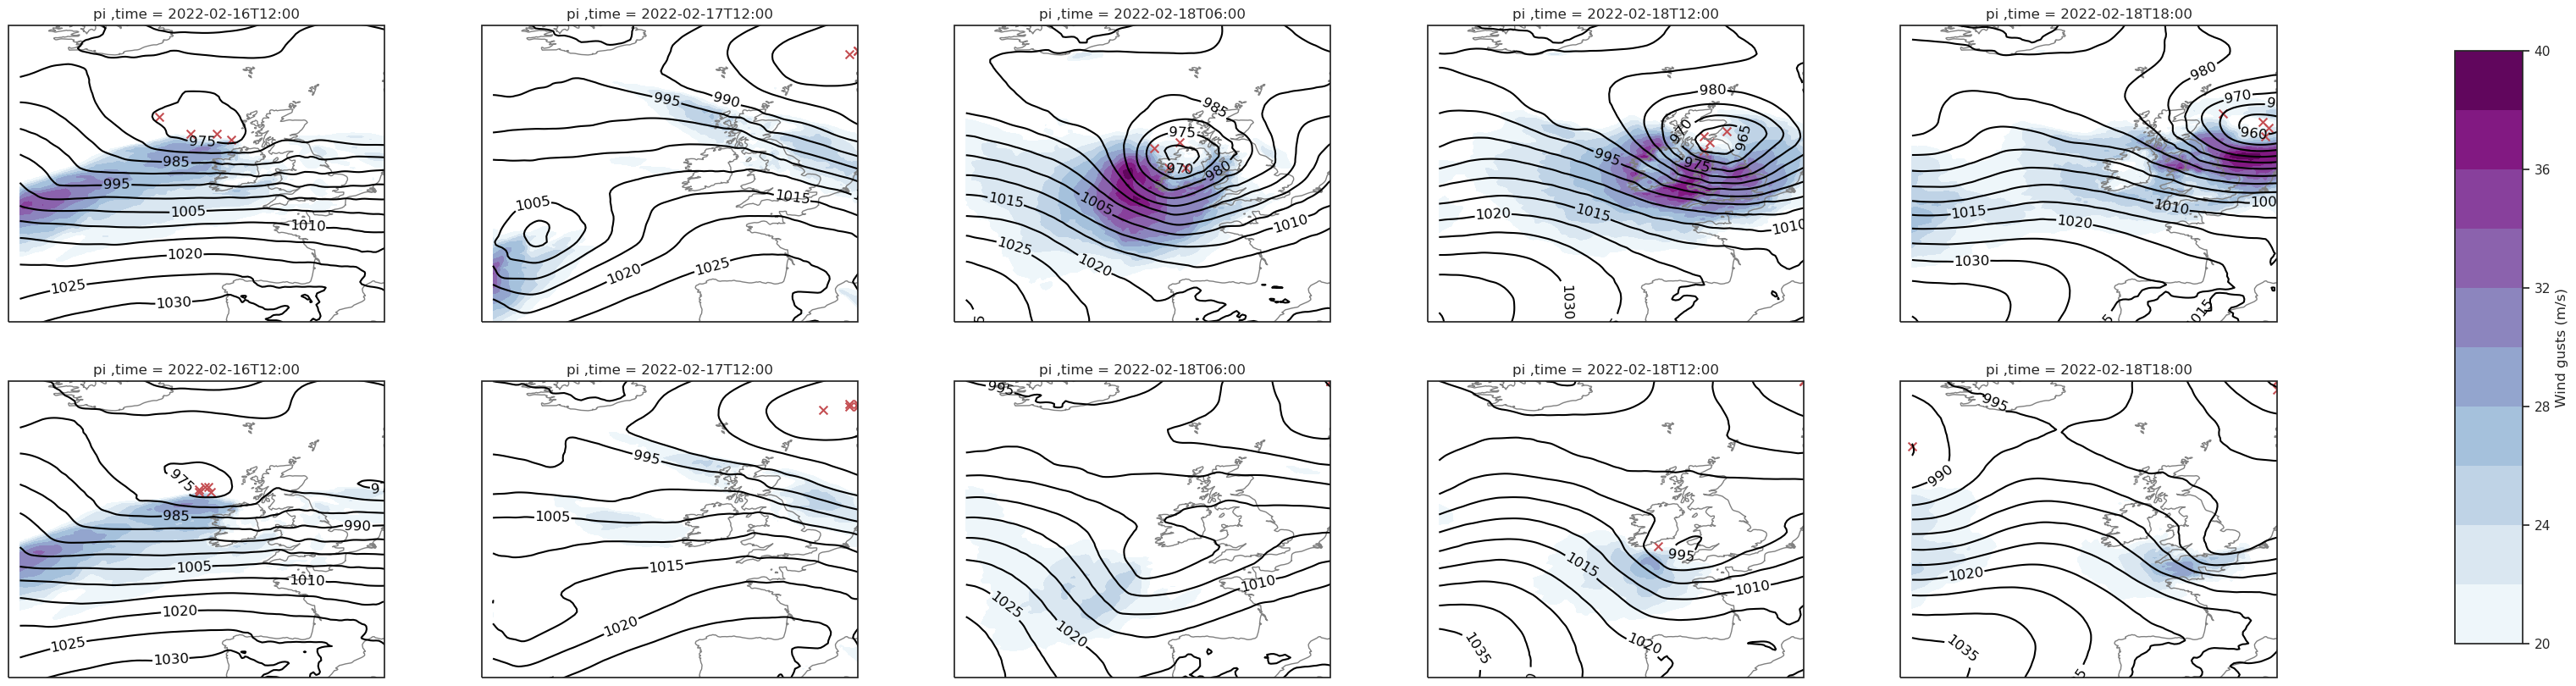

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


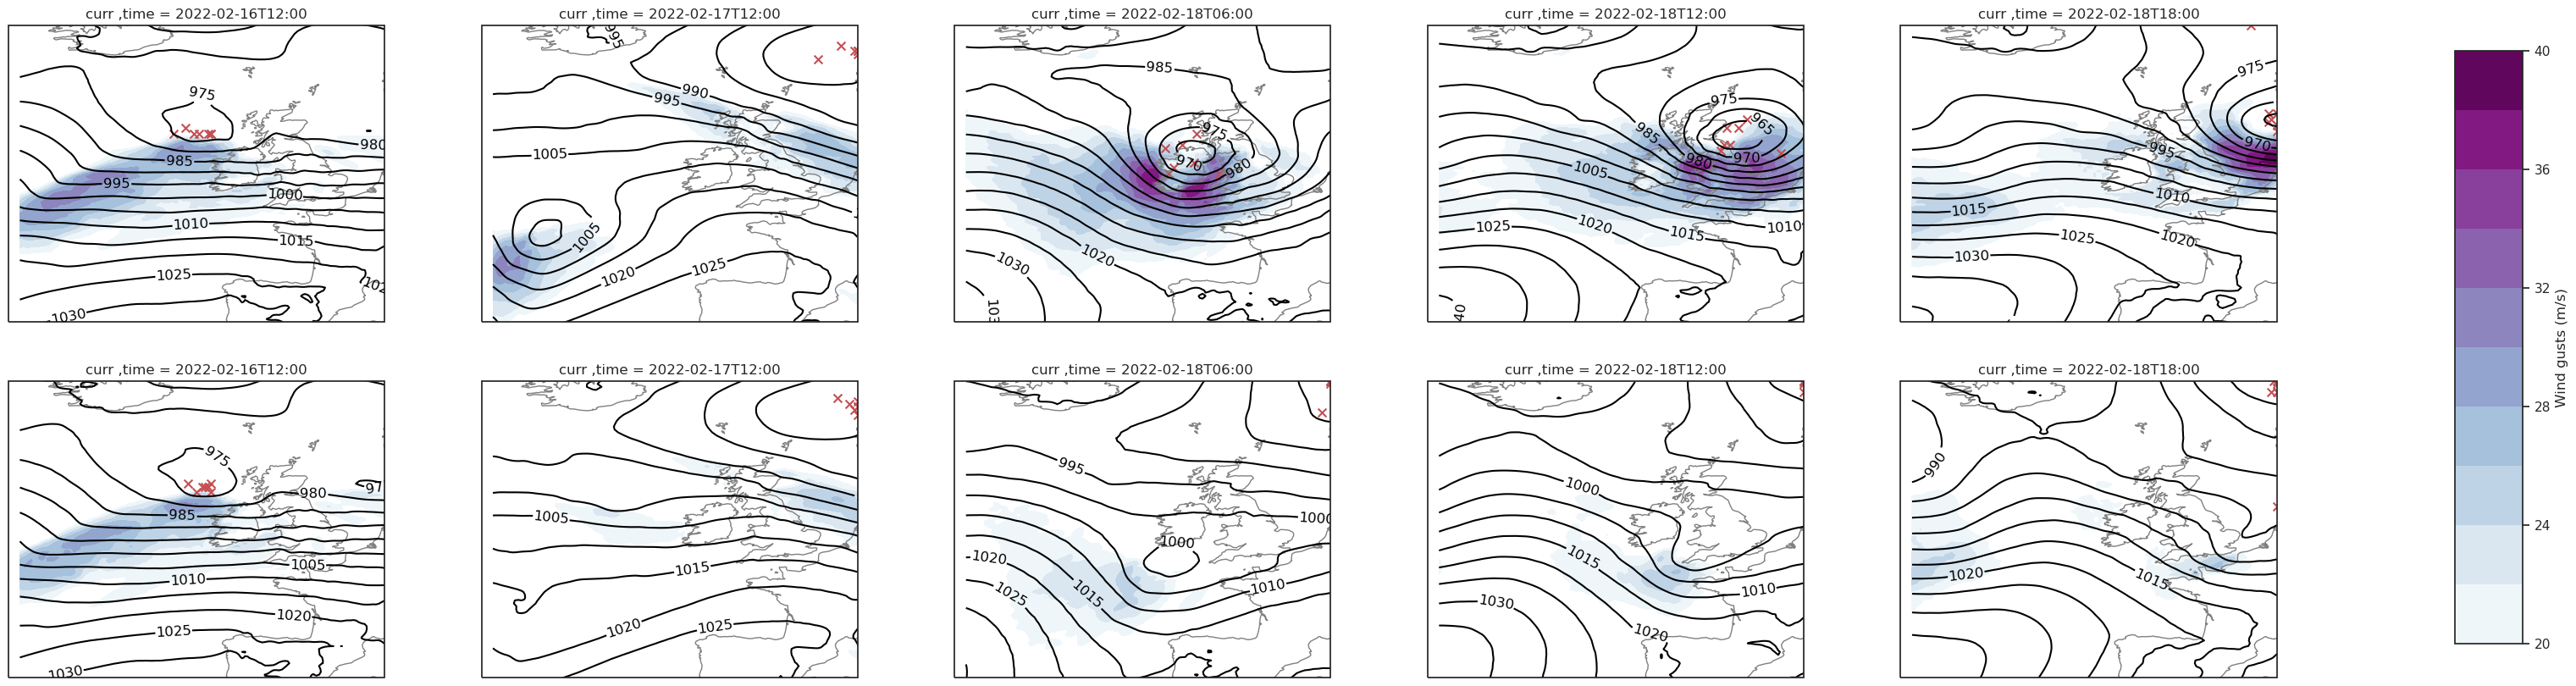

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


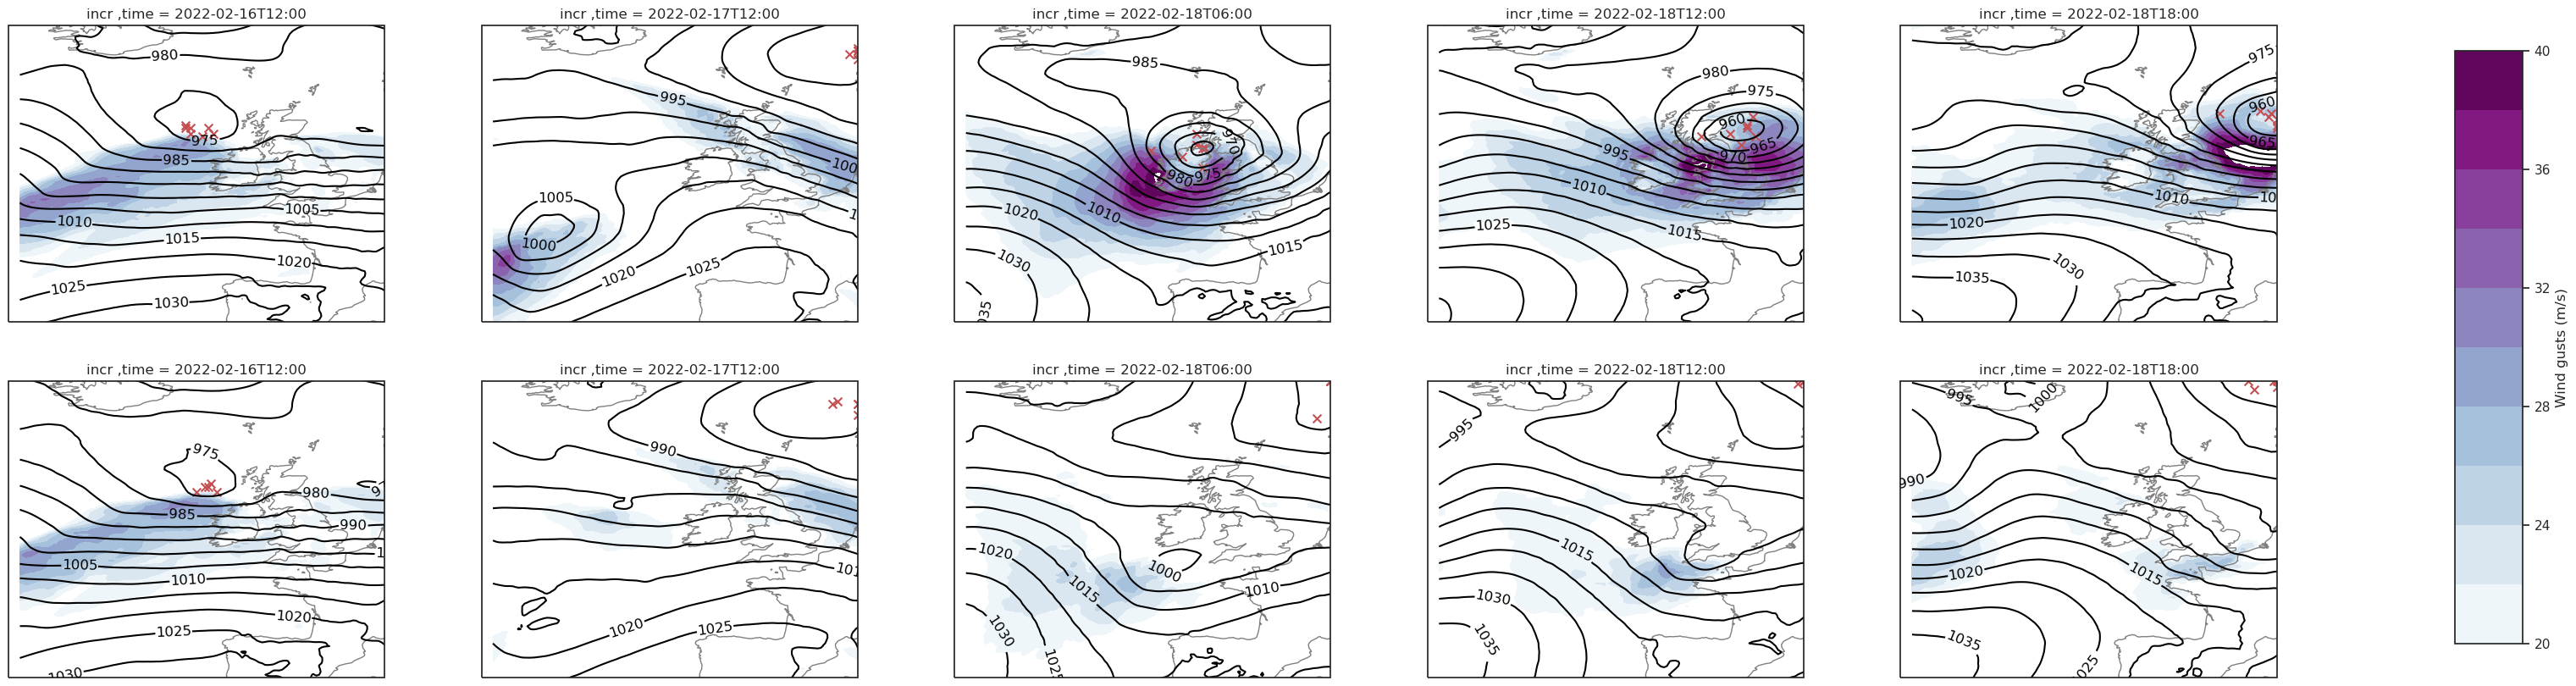

In [11]:
projection = ccrs.PlateCarree()
p_max = 1040
p_min = 960

fg10_min = 20
fg10_max = 40

# fg10_min = 0
# fg10_max = 1

longitude = eps_weak[0].longitude.values
latitude = eps_weak[0].latitude.values
wind_threshold_cases = [enscount_extreme_fg10, enscount_weak_fg10]
full_eps_composite_cases = [eps_extreme, eps_weak]


for e, experiment in enumerate(experiments):
    for c, case in enumerate([eps_extreme_mean, eps_weak_mean]): 
        for t, time in enumerate(eps_weak_mean[0].time):

            fg10_vals = case[e].sel(time = time).fg10.values  # wind averages
            # fg10_vals = wind_threshold_cases[c][e].sel(time = time).fg10.values/numbers[i][c][experiment]  # wind threshold exceedance
            p_vals = case[e].sel(time = time).msl.values/100  # divide by 100 for Pa to hPa

            # figure and map setup
            fig = plt.figure(1, figsize=(40, 10))
            ax = plt.subplot(2,len(time_steps),int(c*len(time_steps)+t+1), projection = projection)
            ax.set_extent([lon_min-13, lon_max, lat_min-5, lat_max+6], projection)
            ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

            # fg10 as shading
            clevs_fg10 = np.linspace(fg10_min, fg10_max, 11)  # 17
            cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                            transform=projection)

            # isobars as contours
            clevs_p = np.linspace(p_min, p_max, 17) 
            cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                            transform=projection)
            plt.clabel(cs, fmt='%d')
            ax.set_title(experiment+" ,time = " + str(time.values)[:16])

            # dots for pressure minimum
            dummy = full_eps_composite_cases[c][e].sel(time=time, latitude=slice(lat_max+6,lat_min-5), longitude=slice(lon_min-13,lon_max)).msl
            min_pres_loc = dummy.isel(dummy.argmin(dim=["latitude", "longitude"]))
            ax.scatter(min_pres_loc.longitude, min_pres_loc.latitude, marker = 'x', s = 50, c = 'r')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)')

    # plt.savefig('figures/07_composite_averages_time_evolution_'+experiment+'_inidate_'+inidate+'.png')
    # plt.savefig('figures/07_composite_averages_time_evolution_'+experiment+'_inidate_'+inidate+'.pdf')
    plt.show()
        

## Friday 12UTC comparison of experiments

In [52]:
eps_extreme_mean = [x.sel(time = '2022-02-18 12').mean(dim = 'number') for x in eps_extreme]
eps_weak_mean = [x.sel(time = '2022-02-18 12').mean(dim = 'number') for x in eps_weak]

/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/home/e/ermis/nobackups/miniconda3/envs/storm_eunice39/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


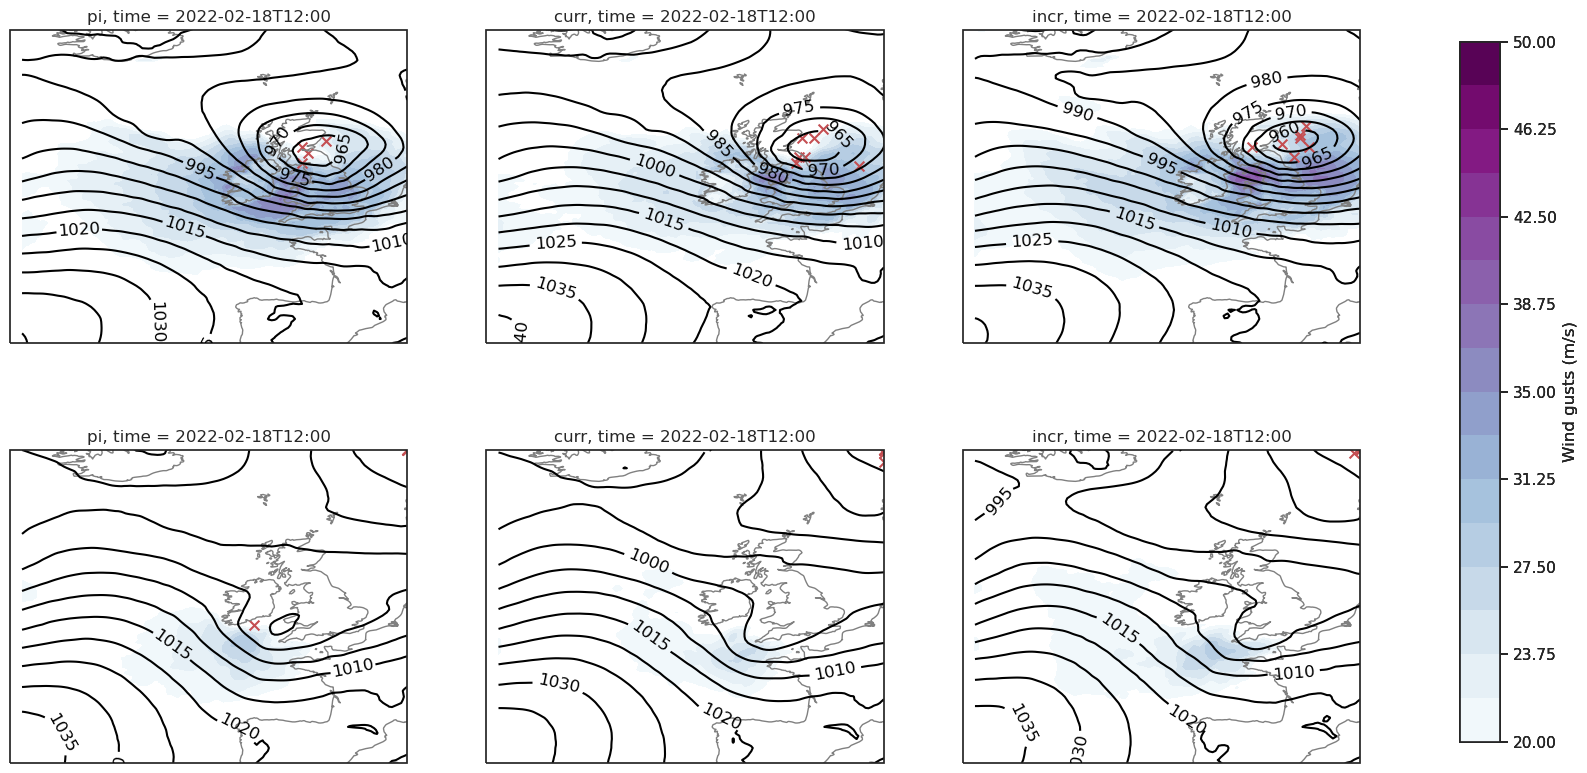

In [53]:
projection = ccrs.PlateCarree()
p_max = 1040
p_min = 960

fg10_min = 20
fg10_max = 50

longitude = eps_weak[0].longitude.values
latitude = eps_weak[0].latitude.values

time = eps_extreme_mean[0].time
for e, experiment in enumerate(['pi', 'curr', 'incr']):
    for c, case in enumerate([eps_extreme_mean, eps_weak_mean]):    
        fg10_vals = case[e].fg10.values[:,:]
        p_vals = case[e].msl.values[:,:]/100

        # figure and map setup
        fig = plt.figure(1, figsize=(20, 10))
        ax = plt.subplot(2,3,int(e+c*3+1), projection = projection) # TODO fix indices
        ax.set_extent([lon_min-13, lon_max, lat_min-5, lat_max+6], projection)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'), color = 'grey')

        # fg10 as shading
        clevs_fg10 = np.linspace(fg10_min, fg10_max, 17)
        cf = ax.contourf(longitude, latitude, fg10_vals, clevs_fg10, cmap=plt.cm.BuPu,
                        transform=projection)

        #isobars as contours
        clevs_p = np.linspace(p_min, p_max, 17)
        cs = ax.contour(longitude, latitude, p_vals, clevs_p, colors='black',
                        transform=projection)
        plt.clabel(cs, fmt='%d')
        ax.set_title(experiment+", time = " + str(time.values)[:16])

        # dots for pressure minimum
        dummy = full_eps_composite_cases[c][e].sel(time=time, latitude=slice(lat_max+6,lat_min-5), longitude=slice(lon_min-13,lon_max)).msl
        min_pres_loc = dummy.isel(dummy.argmin(dim=["latitude", "longitude"]))
        ax.scatter(min_pres_loc.longitude, min_pres_loc.latitude, marker = 'x', s = 50, c = 'r')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    fig.colorbar(cf, cax=cbar_ax, label='Wind gusts (m/s)')

# plt.savefig('figures/07_composite_averages_2022-02-18T12_inidate'+inidate+'.png')
# plt.savefig('figures/07_composite_averages_2022-02-18T12_inidate'+inidate+'.pdf')